In [203]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from ast import literal_eval
import seaborn as sns

# Đọc file CSV
df_jd = pd.read_csv('../../data/clean/clean_jobs_v2.csv')
df_cr = pd.read_csv('../../data/clean/clean_resumes_v2.csv')

print(f"Số lượng Job Descriptions: {len(df_jd)}")
print(f"Số lượng Candidate Resumes: {len(df_cr)}")

Số lượng Job Descriptions: 2513
Số lượng Candidate Resumes: 690


In [131]:
df_jd.describe()


,location_group,type_salary
count,2513.000000,2513.000000
mean,2.500597,3.335058
std,0.728254,1.733645
min,1.000000,1.000000
25%,2.000000,2.000000
50%,3.000000,5.000000
75%,3.000000,5.000000
max,3.000000,5.000000


In [167]:
df_cr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Category          690 non-null    object
 1   Resume            690 non-null    object
 2   resume_cleaned    690 non-null    object
 3   primary_skills    690 non-null    object
 4   secondary_skills  690 non-null    object
 5   adjectives        690 non-null    object
 6   adverbs           690 non-null    object
 7   id                690 non-null    object
dtypes: object(8)
memory usage: 43.3+ KB


In [204]:

# Hàm chuyển đổi an toàn: xử lý cả chuỗi và danh sách
def safe_literal_eval(val):
    if isinstance(val, list):
        return val
    if pd.isna(val):
        return []
    try:
        return literal_eval(val)
    except (ValueError, SyntaxError):
        return []
def jaccard_similarity(list1, list2):
    def normalize_tokens(lst):
        return set([str(x).strip().lower() for x in lst if str(x).strip()])

    set1, set2 = normalize_tokens(list1), normalize_tokens(list2)

    set1, set2 = set(list1), set(list2)
    return len(set1 & set2) / len(set1 | set2) if set1 | set2 else 0

def assign_suitability(score):
    if score > 0.65:
        return 'Most Suitable'          # Top 25%
    elif score > 0.3:
        return 'Moderately Suitable'    # Khoảng giữa
    else:
        return 'Not Suitable'




In [5]:
print(jaccard_similarity(['python'],['python']))

1.0


In [169]:
pd.DataFrame(df_jd)

,id,title,company,location,salary,description,requirements,skills,language,skills_en,...,requirements_en,description_cleaned,requirements_cleaned,skills_cleaned,location_group,type_salary,primary_skills,secondary_skills,adjectives,adverbs
0,JOB_0,MLops Engineer,Trusting Social,Ho Chi Minh,You'll love it,looking qualified mlops engineer ekyc project ...,bs ms computer science related fields 1 3 year...,"MLOps, Python, Linux, Docker, Data Science, Te...",en,"MLOps, Python, Linux, Docker, Data Science, Te...",...,bs ms computer science related fields 1 3 year...,looking qualified mlops engineer ekyc project ...,bs ms computer science related fields 1 3 year...,"['MLOps', 'Python', 'Linux', 'Docker', 'Data S...",2,5,"['python', 'java', 'javascript', 'c', 'tensorf...","['git', 'docker', 'linux']","['qualified', 'basic', 'great', 'novel', 'tiny...",[]
1,JOB_1,"Senior DevOps Engineer (Cloud, AWS)",TymeX,Ho Chi Minh,You'll love it,seeking experienced senior devops engineer aws...,requirements degree computer science informati...,"AWS, DevOps, Cloud, Cloud-native Architecture,...",en,"AWS, DevOps, Cloud, Cloud-native Architecture,...",...,requirements degree computer science informati...,seeking experienced senior devops engineer aws...,requirements degree computer science informati...,"['AWS', 'DevOps', 'Cloud', 'Cloud-native Archi...",2,5,"['python', 'bash', 'aws', 'software', 'ci cd',...","['git', 'gitlab', 'git flow', 'docker', 'jenki...","['ansible', 'continuous', 'main', 'periodic', ...","['occasionally', 'effectively', 'quickly', 'in..."
2,JOB_2,VTS - Chuyên Viên Quản Trị Dự Án (Agile/ Azure),Viettel Group,Ha Noi,You'll love it,ecotek dắt ecopark phát triển trở thành mô hìn...,tư logic tư hướng giải pháp tư phản biện kỹ nă...,"Project Management, Business Analysis, Presale...",vi,"Project Management, Business Analysis, Presale...",...,Private Logic Private solutions to criticize c...,ecotek dắt ecopark phát triển trở thành mô hìn...,tư logic tư hướng giải pháp tư phản biện kỹ nă...,"['Project Management', 'Business Analysis', 'P...",1,5,"['software', 'network', 'sales', 'production']",[],"['private', 'technical', 'lightweight', 'speci...","['directly', 'currently']"
3,JOB_3,VTS - Tư Vấn Giải Pháp - Presales Engineer,Viettel Group,Ha Noi,You'll love it,gia nhập vũ trụ công nghệ viettel đắm chìm hàn...,nghiệp đại học trở chuyên ngành cntt điện tử v...,"Presale, Business Analysis, Salesforce, Pre-sa...",vi,"Presale, Business Analysis, Salesforce, Pre-sa...",...,University of Electronics and Telecommunicatio...,gia nhập vũ trụ công nghệ viettel đắm chìm hàn...,nghiệp đại học trở chuyên ngành cntt điện tử v...,"['Presale', 'Business Analysis', 'Salesforce',...",1,5,"['cloud', 'blockchain', 'iot']",[],"['important', 'technical', 'suitable', 'genuin...",['boldly']
4,JOB_4,"VHT - Embedded Software Engineer (Linux, C++)",Viettel Group,Ha Noi,"650 - 2,200 USD",1200 nhân chất tổng công ty công nghiệp công n...,nghiệp đại học quy trở chuyên ngành công nghệ ...,"Embedded, C++, Linux, C language, Embedded Eng...",vi,"Embedded, C++, Linux, C language, Embedded Eng...",...,"University of University, specialized in telec...",1200 nhân chất tổng công ty công nghiệp công n...,nghiệp đại học quy trở chuyên ngành công nghệ ...,"['Embedded', 'C++', 'Linux', 'C language', 'Em...",1,2,"['c', 'systems']",[],"['triển', 'electronic', 'human']",[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2508,JOB_2508,CTV Quản Lý Dự Án,Công ty CP An ninh mạng Việt Nam,Hà Nội,Thoả thuận,mô tả công dõi kế hoạch dự án triển khai kiểm ...,kỹ năng giao tiếp quản lý thời gian quản lý ng...,NaN,vi,NaN,...,Communication skills management time for risk ...,mô tả công dõi kế hoạch dự án triển khai kiểm ...,kỹ năng giao tiếp quản lý thời gian quản lý ng...,NaN,3,5,[],[],"['happy', 'medium']","['openly', 'online']"
2509,JOB_2509,Nhân Viên Thiết Kế (Designer),Công Ty TNHH Thương Mại - Dịch Vụ Hoa Mai,Hồ Chí Minh,10 - 15 triệu,mô tả công - 

In [106]:

math.log1p(20)

3.044522437723423

In [205]:
import math

# Khởi tạo danh sách lưu điểm similarity
similarity_scores = []
# Chuyển từ chuỗi sang list
for col in ['primary_skills', 'secondary_skills', 'adjectives', 'adverbs']:
    df_jd[col] = df_jd[col].apply(safe_literal_eval)
    df_cr[col] = df_cr[col].apply(safe_literal_eval)
# Cắt giới hạn số từ
MAX_WORDS = 5
for col in ['adjectives', 'adverbs']:
    df_jd[col] = df_jd[col].apply(lambda x: x[:MAX_WORDS] if isinstance(x, list) else [])
    df_cr[col] = df_cr[col].apply(lambda x: x[:MAX_WORDS] if isinstance(x, list) else [])

# Tính similarity cho từng cặp JD–CR
for _, jd in df_jd.iterrows():
    for _, cr in df_cr.iterrows():

        primary_sim = jaccard_similarity(jd['primary_skills'], cr['primary_skills'])
        secondary_sim = jaccard_similarity(jd['secondary_skills'], cr['secondary_skills'])
        adj_sim = jaccard_similarity(jd['adjectives'], cr['adjectives'])
        adj_weight = len(cr['adjectives']) if cr['adjectives'] else 1

        total_similarity = primary_sim + secondary_sim + (adj_sim * math.log1p(adj_weight))

        scores = {
            'jd_id': jd['id'],
            'cr_id': cr['id'],
            'cr_category': cr['Category'],
            'jd_name': jd['title'],
            'primary_skills_sim': primary_sim,
            'secondary_skills_sim': secondary_sim,
            'adjectives_sim': adj_sim,
            'adj_weight': adj_weight,
            'total_similarity': total_similarity,
            'suitability': assign_suitability(total_similarity)
        }

        similarity_scores.append(scores)

# Tạo DataFrame từ danh sách điểm
df_similarity = pd.DataFrame(similarity_scores)





In [198]:
df_similarity.describe()

,primary_skills_sim,secondary_skills_sim,adjectives_sim,adj_weight,total_similarity
count,1.733970e+06,1.733970e+06,1.733970e+06,1.733970e+06,1.733970e+06
mean,3.940757e-02,1.478357e-02,8.983212e-03,4.372464e+00,6.988268e-02
std,7.005007e-02,7.094355e-02,3.339639e-02,1.264497e+00,1.231257e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00,0.000000e+00
75%,6.666667e-02,0.000000e+00,0.000000e+00,5.000000e+00,1.000000e-01
max,1.000000e+00,1.000000e+00,5.000000e-01,5.000000e+00,1.484799e+00


In [185]:
def evaluate_similarity_by_max_words(df_jd_raw, df_cr_raw, min_words=5, max_words=30):
    results = []

    for MAX_WORDS in range(min_words, max_words + 1):
        df_jd = df_jd_raw.copy()
        df_cr = df_cr_raw.copy()

        # Chuyển từ chuỗi sang list
        for col in ['primary_skills', 'secondary_skills', 'adjectives', 'adverbs']:
            df_jd[col] = df_jd[col].apply(safe_literal_eval)
            df_cr[col] = df_cr[col].apply(safe_literal_eval)

        # Cắt giới hạn số từ
        for col in ['adjectives', 'adverbs']:
            df_jd[col] = df_jd[col].apply(lambda x: x[:MAX_WORDS] if isinstance(x, list) else [])
            df_cr[col] = df_cr[col].apply(lambda x: x[:MAX_WORDS] if isinstance(x, list) else [])

        # Tính similarity
        similarity_scores = []
        for _, jd in df_jd.iterrows():
            for _, cr in df_cr.iterrows():

                primary_sim = jaccard_similarity(jd['primary_skills'], cr['primary_skills'])
                secondary_sim = jaccard_similarity(jd['secondary_skills'], cr['secondary_skills'])
                adj_sim = jaccard_similarity(jd['adjectives'], cr['adjectives'])
                adj_weight = len(cr['adjectives']) if cr['adjectives'] else 1

                total_similarity = primary_sim + secondary_sim + (adj_sim * adj_weight)

                scores = {
                    'jd_id': jd['id'],
                    'cr_id': cr['id'],
                    'cr_category': cr['Category'],
                    'jd_name': jd['title'],
                    'primary_skills_sim': primary_sim,
                    'secondary_skills_sim': secondary_sim,
                    'adjectives_sim': adj_sim,
                    'adj_weight': adj_weight,
                    'total_similarity': total_similarity,
                    'suitability': assign_suitability(total_similarity)
                }
                similarity_scores.append(scores)

        df_sim = pd.DataFrame(similarity_scores)

        # Lọc kết quả
        df_sim = df_sim[
            (df_sim['primary_skills_sim'] > 0) &
            (df_sim['secondary_skills_sim'] > 0) &
            (df_sim['adjectives_sim'] > 0)
        ]
        df_sim = df_sim.drop_duplicates(subset=[
            'primary_skills_sim',
            'secondary_skills_sim',
            'adjectives_sim',
            'adj_weight',
            'total_similarity'
        ])

        # Reset index nếu muốn
        df_sim.reset_index(drop=True, inplace=True)
        df_sim.dropna(inplace=True)
        print(df_sim.describe())

        # Lưu kết quả thống kê
        result = {
            'MAX_WORDS': MAX_WORDS,
            'n_matches': len(df_sim),
            'avg_total_similarity': df_sim['total_similarity'].mean() if not df_sim.empty else 0
        }
        results.append(result)

    return pd.DataFrame(results)

df_results = evaluate_similarity_by_max_words(df_jd, df_cr)

# In ra bảng kết quả
print(df_results)

KeyboardInterrupt: 

In [206]:
df_similarity = df_similarity.drop_duplicates(subset=[
    'primary_skills_sim',
    'secondary_skills_sim',
    'adjectives_sim',
    'adj_weight',
    'total_similarity'
])

# Reset index nếu muốn
df_similarity.reset_index(drop=True, inplace=True)

In [176]:
df_similarity.dropna(inplace=True)

In [207]:
df_similarity.describe()

,primary_skills_sim,secondary_skills_sim,adjectives_sim,adj_weight,total_similarity
count,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000
mean,0.140802,0.139886,0.039946,4.619374,0.348822
std,0.105130,0.158693,0.070022,0.906011,0.208240
min,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.066667,0.000000,0.000000,5.000000,0.205263
50%,0.119048,0.100000,0.000000,5.000000,0.309203
75%,0.187500,0.200000,0.111111,5.000000,0.449410
max,1.000000,1.000000,0.500000,5.000000,1.484799


In [178]:
df_similarity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2375 entries, 0 to 2374
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   jd_id                 2375 non-null   object 
 1   cr_id                 2375 non-null   object 
 2   cr_category           2375 non-null   object 
 3   jd_name               2375 non-null   object 
 4   primary_skills_sim    2375 non-null   float64
 5   secondary_skills_sim  2375 non-null   float64
 6   adjectives_sim        2375 non-null   int64  
 7   adj_weight            2375 non-null   int64  
 8   total_similarity      2375 non-null   float64
 9   suitability           2375 non-null   object 
dtypes: float64(3), int64(2), object(5)
memory usage: 185.7+ KB


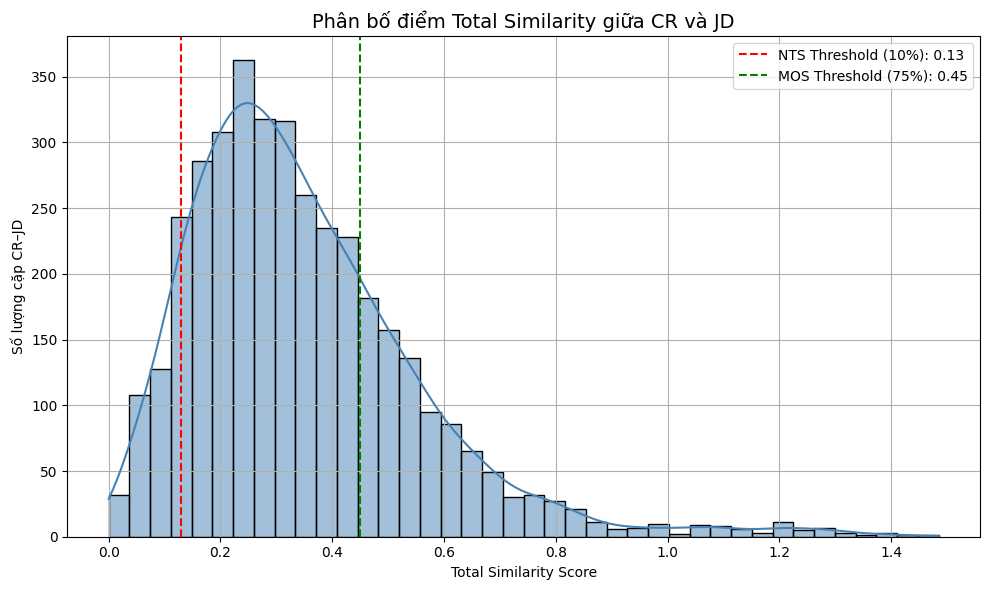

In [189]:
import matplotlib.pyplot as plt
import seaborn as sns

# Thiết lập kiểu đồ họa
plt.figure(figsize=(10, 6))
sns.histplot(df_similarity['total_similarity'], bins=40, kde=True, color='steelblue')

# Đánh dấu phân vị nếu bạn dùng để gán nhãn
threshold_nts = df_similarity['total_similarity'].quantile(0.10)
threshold_mos = df_similarity['total_similarity'].quantile(0.75)

# Vẽ đường phân biệt ngưỡng suitability
plt.axvline(threshold_nts, color='red', linestyle='--', label=f'NTS Threshold (10%): {threshold_nts:.2f}')
plt.axvline(threshold_mos, color='green', linestyle='--', label=f'MOS Threshold (75%): {threshold_mos:.2f}')

plt.title('Phân bố điểm Total Similarity giữa CR và JD', fontsize=14)
plt.xlabel('Total Similarity Score')
plt.ylabel('Số lượng cặp CR–JD')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



Phân bố nhãn Suitability:
suitability
Not Suitable           1814
Moderately Suitable    1697
Most Suitable           288
Name: count, dtype: int64

Tổng số cặp JD-CR: 3799

Thống kê Primary Skills Similarity:
Mean: 0.1408
Median: 0.1190
Min: 0.0000
Max: 1.0000


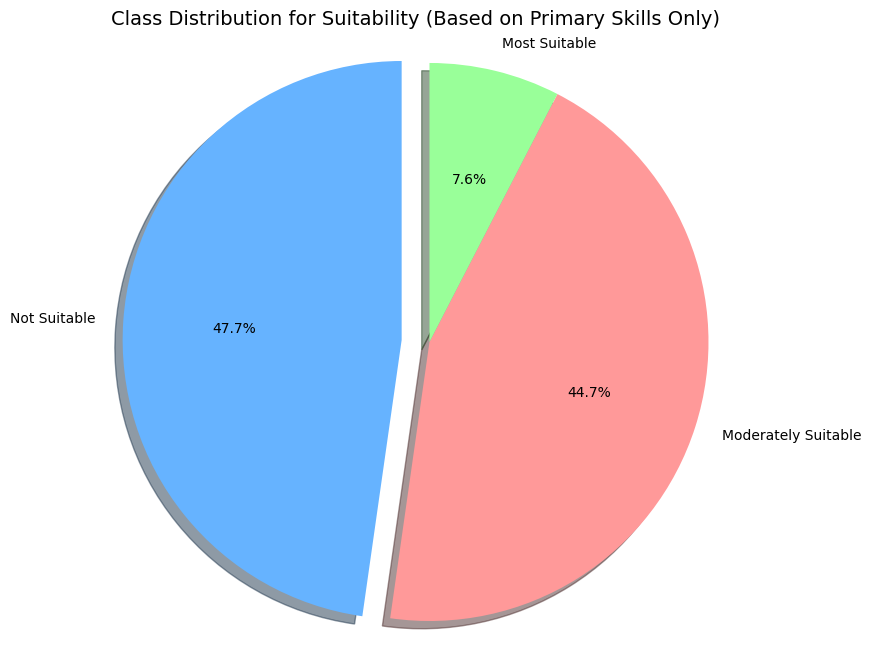


=== SUMMARY ===
Total JD records: 2513
Total CR records: 690
Total similarity pairs: 3799
Match rate: 0.00%
Neutral rate: 0.00%
Mismatch rate: 0.00%


In [208]:

# Kiểm tra phân bố nhãn
class_counts = df_similarity['suitability'].value_counts()
print("\nPhân bố nhãn Suitability:")
print(class_counts)
print(f"\nTổng số cặp JD-CR: {len(df_similarity)}")

# Thống kê điểm similarity
print(f"\nThống kê Primary Skills Similarity:")
print(f"Mean: {df_similarity['primary_skills_sim'].mean():.4f}")
print(f"Median: {df_similarity['primary_skills_sim'].median():.4f}")
print(f"Min: {df_similarity['primary_skills_sim'].min():.4f}")
print(f"Max: {df_similarity['primary_skills_sim'].max():.4f}")

# Tạo explode động cho biểu đồ
labels = class_counts.index
sizes = class_counts.values
colors = ['#66b3ff', '#ff9999', '#99ff99'][:len(labels)]
explode = [0.1 if i == 0 else 0 for i in range(len(labels))]

# Vẽ biểu đồ tròn
plt.figure(figsize=(10, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, 
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Class Distribution for Suitability (Based on Primary Skills Only)', fontsize=14)
plt.axis('equal')
plt.savefig('class_distribution_suitability.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n=== SUMMARY ===")
print(f"Total JD records: {len(df_jd)}")
print(f"Total CR records: {len(df_cr)}")
print(f"Total similarity pairs: {len(df_similarity)}")
print(f"Match rate: {(class_counts.get('Match', 0) / len(df_similarity) * 100):.2f}%")
print(f"Neutral rate: {(class_counts.get('Neutral', 0) / len(df_similarity) * 100):.2f}%")
print(f"Mismatch rate: {(class_counts.get('Mismatch', 0) / len(df_similarity) * 100):.2f}%")

In [ ]:
# Lấy 20 dòng đầu tiên có điểm primary_skills_sim cao nhất
top_20_similarities = df_similarity.sort_values(by='primary_skills_sim', ascending=False).head(10000)

# In ra các cột cần thiết
print(top_20_similarities[['jd_id', 'cr_category', 'primary_skills_sim','secondary_skills_sim', 'total_similarity', 'suitability']])


         jd_id       cr_category  primary_skills_sim  secondary_skills_sim  \
122      JOB_4    Civil Engineer            1.000000              0.000000   
2294  JOB_2347  Business Analyst            0.833333              0.000000   
2323  JOB_2467  DotNet Developer            0.714286              0.000000   
339     JOB_34    Civil Engineer            0.666667              0.000000   
1554  JOB_1277    Java Developer            0.625000              0.000000   
...        ...               ...                 ...                   ...   
1287  JOB_1206      Data Science            0.022222              0.000000   
2245  JOB_2244   DevOps Engineer            0.022222              0.200000   
1289  JOB_1210      Data Science            0.021739              0.111111   
1288  JOB_1210      Data Science            0.021277              0.111111   
1869  JOB_1655      Data Science            0.021277              0.083333   

      total_similarity          suitability  
122           1.0

In [121]:
pd.DataFrame(df_similarity)

,jd_id,cr_id,cr_category,jd_name,primary_skills_sim,secondary_skills_sim,adjectives_sim,adj_weight,total_similarity
20,JOB_12,CANDIDATE_86,Advocate,Kỹ Sư Giải Pháp Mạng (Network Solution Engineer),0.095238,0.105263,0.285714,9,0.858383
21,JOB_12,CANDIDATE_96,Advocate,Kỹ Sư Giải Pháp Mạng (Network Solution Engineer),0.095238,0.105263,0.285714,9,0.858383
30,JOB_12,CANDIDATE_296,Civil Engineer,Kỹ Sư Giải Pháp Mạng (Network Solution Engineer),0.190476,0.105263,0.285714,9,0.953621
31,JOB_12,CANDIDATE_302,Civil Engineer,Kỹ Sư Giải Pháp Mạng (Network Solution Engineer),0.190476,0.105263,0.285714,9,0.953621
32,JOB_12,CANDIDATE_308,Civil Engineer,Kỹ Sư Giải Pháp Mạng (Network Solution Engineer),0.190476,0.105263,0.285714,9,0.953621
...,...,...,...,...,...,...,...,...,...
12685,JOB_2492,CANDIDATE_570,Python Developer,Chuyên Viên Thiết Kế 2D,0.500000,0.181818,0.222222,2,0.925954
12686,JOB_2492,CANDIDATE_576,Python Developer,Chuyên Viên Thiết Kế 2D,0.500000,0.181818,0.222222,2,0.925954
12687,JOB_2492,CANDIDATE_582,Python Developer,Chuyên Viên Thiết Kế 2D,0.500000,0.181818,0.222222,2,0.925954
12688,JOB_2492,CANDIDATE_588,Python Developer,Chuyên Viên Thiết Kế 2D,0.500000,0.181818,0.222222,2,0.925954


In [ ]:
df_similarity['suitability'] = df_similarity['suitability'].map({
    'Not Suitable': 0,
    'Moderately Suitable': 1,
    'Most Suitable': 2
})


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Sau khi tính xong adj_weight
scaler = MinMaxScaler()
df_similarity['scaled_adj_weight'] = scaler.fit_transform(df_similarity[['adj_weight']])
df_similarity['total_similarity_v2'] = df_similarity['primary_skills_sim'] + \
                                       df_similarity['secondary_skills_sim'] + \
                                       (df_similarity['adjectives_sim'] * df_similarity['scaled_adj_weight'])


In [ ]:
import numpy as np
df_similarity['adj_weight_log'] = np.log1p(df_similarity['adj_weight'])  # log(1 + x)
df_similarity['total_similarity_v3'] = df_similarity['primary_skills_sim'] + \
                                       df_similarity['secondary_skills_sim'] + \
                                       (df_similarity['adjectives_sim'] * df_similarity['adj_weight_log'])


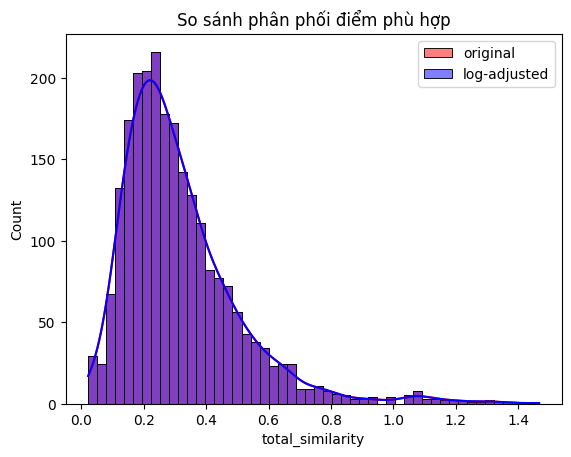

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df_similarity['total_similarity'], bins=50, color='red', label='original', kde=True)
sns.histplot(df_similarity['total_similarity_v3'], bins=50, color='blue', label='log-adjusted', kde=True)
plt.legend()
plt.title("So sánh phân phối điểm phù hợp")
plt.show()


In [ ]:
df_similarity.describe()

,primary_skills_sim,secondary_skills_sim,adjectives_sim,adj_weight,total_similarity,suitability,scaled_adj_weight,total_similarity_v2,adj_weight_log,total_similarity_v3
count,2347.000000,2347.000000,2347.0,2347.0,2347.000000,2347.000000,2347.0,2347.000000,2347.000000,2347.000000
mean,0.149947,0.165966,0.0,1.0,0.315913,1.035364,0.0,0.315913,0.693147,0.315913
std,0.097594,0.158324,0.0,0.0,0.187814,0.331666,0.0,0.187814,0.000000,0.187814
min,0.021277,0.000000,0.0,1.0,0.022222,0.000000,0.0,0.022222,0.693147,0.022222
25%,0.076923,0.071429,0.0,1.0,0.190476,1.000000,0.0,0.190476,0.693147,0.190476
50%,0.131579,0.125000,0.0,1.0,0.273026,1.000000,0.0,0.273026,0.693147,0.273026
75%,0.200000,0.200000,0.0,1.0,0.392326,1.000000,0.0,0.392326,0.693147,0.392326
max,1.000000,1.000000,0.0,1.0,1.466667,2.000000,0.0,1.466667,0.693147,1.466667


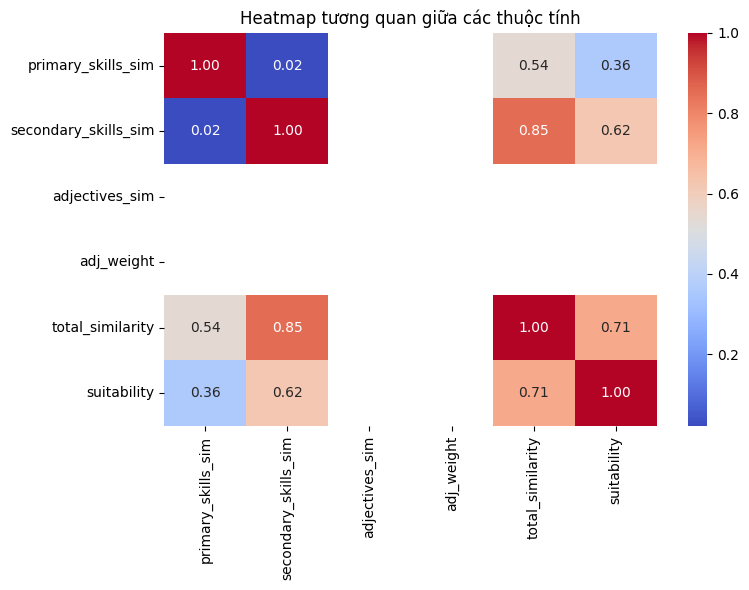

In [ ]:
corr = df_similarity[['primary_skills_sim', 'secondary_skills_sim', 'adjectives_sim', 'adj_weight', 'total_similarity','suitability']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Heatmap tương quan giữa các thuộc tính")
plt.tight_layout()
plt.show()


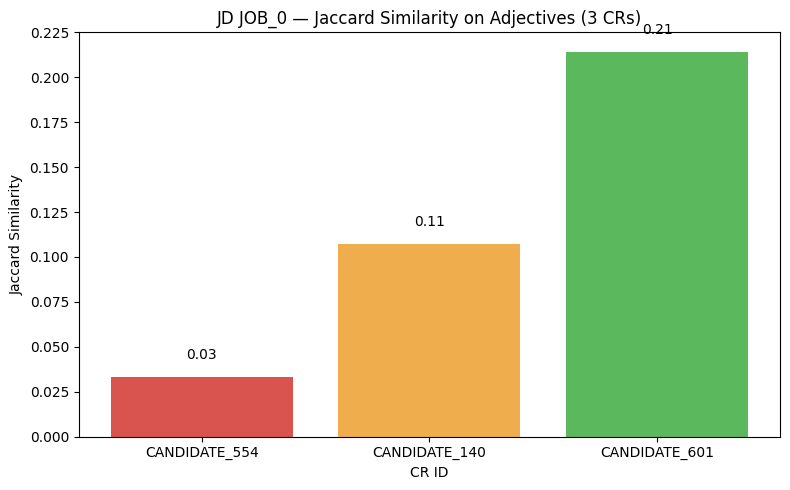

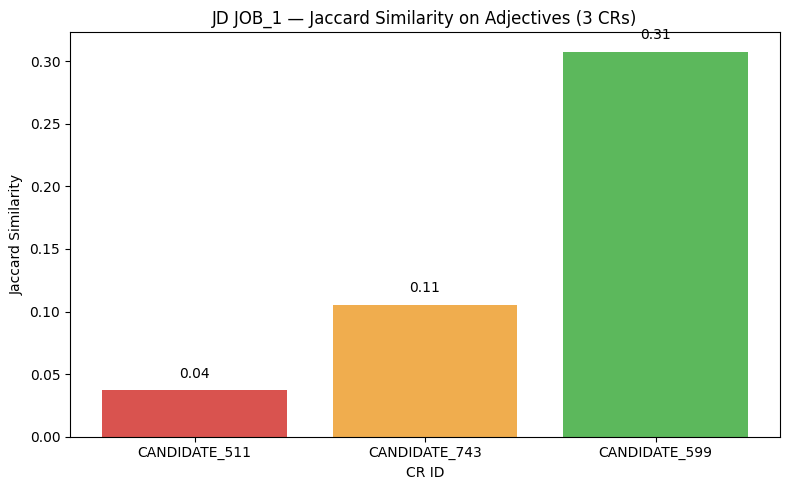

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Giả sử df_similarity đã có các cột: ['jd_id', 'cr_id', 'adjectives_sim']
jd_ids = ['JOB_0', 'JOB_1']
results = []

for jd_id in jd_ids:
    subset = df_similarity[df_similarity['jd_id'] == jd_id][['cr_id', 'primary_skills_sim']]
    subset_sorted = subset.sort_values(by='primary_skills_sim')

    # Lấy: thấp nhất, trung bình, cao nhất
    lowest = subset_sorted.iloc[0]
    median = subset_sorted.iloc[len(subset_sorted) // 2]
    highest = subset_sorted.iloc[-1]

    top3 = pd.DataFrame([lowest, median, highest])
    top3['jd_id'] = jd_id
    results.append(top3)

# Kết hợp lại
df_plot = pd.concat(results, ignore_index=True)

# Vẽ biểu đồ cho từng JD
for jd_id in jd_ids:
    df_sub = df_plot[df_plot['jd_id'] == jd_id]

    plt.figure(figsize=(8, 5))
    plt.bar(df_sub['cr_id'], df_sub['primary_skills_sim'], color=['#d9534f', '#f0ad4e', '#5cb85c'])
    plt.title(f'JD {jd_id} — Jaccard Similarity on Adjectives (3 CRs)')
    plt.xlabel('CR ID')
    plt.ylabel('Jaccard Similarity')
    for i, v in enumerate(df_sub['primary_skills_sim']):
        plt.text(i, v + 0.01, f"{v:.2f}", ha='center')
    plt.tight_layout()
    plt.show()


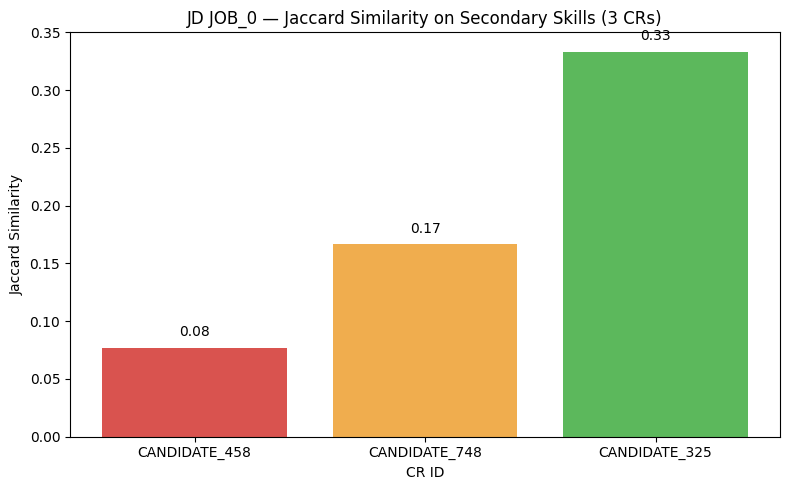

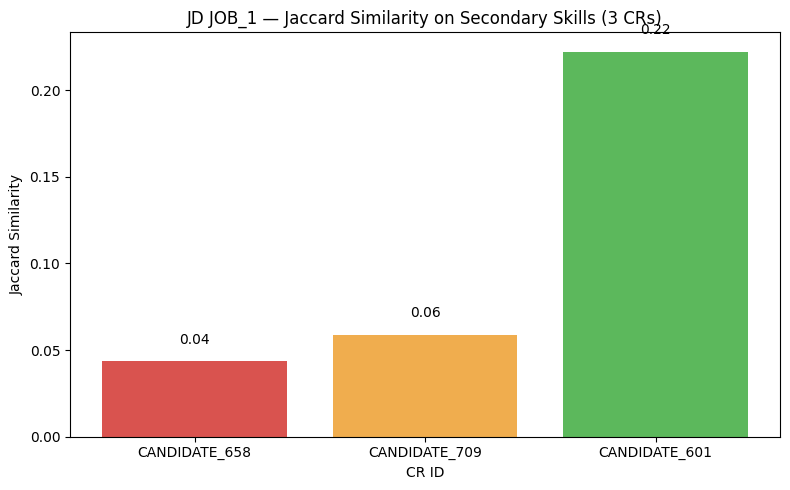

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

jd_ids = ['JOB_0', 'JOB_1']
results = []

for jd_id in jd_ids:
    # Lọc các CR có điểm secondary_skills_sim > 0
    subset = df_similarity[
        (df_similarity['jd_id'] == jd_id) & 
        (df_similarity['secondary_skills_sim'] > 0)
    ][['cr_id', 'secondary_skills_sim']]

    if len(subset) < 3:
        print(f"⚠️ JD {jd_id} có ít hơn 3 CRs với secondary_skills_sim > 0. Bỏ qua.")
        continue

    subset_sorted = subset.sort_values(by='secondary_skills_sim')

    # Lấy: thấp nhất, trung bình, cao nhất
    lowest = subset_sorted.iloc[0]
    median = subset_sorted.iloc[len(subset_sorted) // 2]
    highest = subset_sorted.iloc[-1]

    top3 = pd.DataFrame([lowest, median, highest])
    top3['jd_id'] = jd_id
    results.append(top3)

# Kết hợp lại
df_plot = pd.concat(results, ignore_index=True)

# Vẽ biểu đồ cho từng JD
for jd_id in df_plot['jd_id'].unique():
    df_sub = df_plot[df_plot['jd_id'] == jd_id]

    plt.figure(figsize=(8, 5))
    plt.bar(df_sub['cr_id'], df_sub['secondary_skills_sim'], color=['#d9534f', '#f0ad4e', '#5cb85c'])
    plt.title(f'JD {jd_id} — Jaccard Similarity on Secondary Skills (3 CRs)')
    plt.xlabel('CR ID')
    plt.ylabel('Jaccard Similarity')
    for i, v in enumerate(df_sub['secondary_skills_sim']):
        plt.text(i, v + 0.01, f"{v:.2f}", ha='center')
    plt.tight_layout()
    plt.show()


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

jd_ids = ['JOB_0', 'JOB_1']
results = []

for jd_id in jd_ids:
    # Lọc các CR có điểm adjectives_sim > 0
    subset = df_similarity[
        (df_similarity['jd_id'] == jd_id) & 
        (df_similarity['adjectives_sim'] > 0)
    ][['cr_id', 'adjectives_sim']]

    if len(subset) < 3:
        print(f"⚠️ JD {jd_id} có ít hơn 3 CRs với adjectives_sim > 0. Bỏ qua.")
        continue

    subset_sorted = subset.sort_values(by='adjectives_sim')

    # Lấy: thấp nhất, trung bình, cao nhất
    lowest = subset_sorted.iloc[0]
    median = subset_sorted.iloc[len(subset_sorted) // 2]
    highest = subset_sorted.iloc[-1]

    top3 = pd.DataFrame([lowest, median, highest])
    top3['jd_id'] = jd_id
    results.append(top3)

# Kết hợp lại
df_plot = pd.concat(results, ignore_index=True)

# Vẽ biểu đồ cho từng JD
for jd_id in df_plot['jd_id'].unique():
    df_sub = df_plot[df_plot['jd_id'] == jd_id]

    plt.figure(figsize=(8, 5))
    plt.bar(df_sub['cr_id'], df_sub['adjectives_sim'], color=['#d9534f', '#f0ad4e', '#5cb85c'])
    plt.title(f'JD {jd_id} — Jaccard Similarity on Secondary Skills (3 CRs)')
    plt.xlabel('CR ID')
    plt.ylabel('Jaccard Similarity')
    for i, v in enumerate(df_sub['adjectives_sim']):
        plt.text(i, v + 0.01, f"{v:.2f}", ha='center')
    plt.tight_layout()
    plt.show()


⚠️ JD JOB_0 có ít hơn 3 CRs với adjectives_sim > 0. Bỏ qua.
⚠️ JD JOB_1 có ít hơn 3 CRs với adjectives_sim > 0. Bỏ qua.


ValueError: No objects to concatenate

In [ ]:
print(df_similarity['suitability'].value_counts())
print(df_similarity['suitability'].value_counts(normalize=True))


suitability
2    18110
1     6876
0      878
Name: count, dtype: int64
suitability
2    0.700201
1    0.265852
0    0.033947
Name: proportion, dtype: float64


In [ ]:
# Giả sử bạn dùng total_similarity_v3
df_similarity['suitability_label'] = df_similarity['total_similarity_v3'].apply(lambda x: (
    'Most Suitable' if x >= df_similarity['total_similarity_v3'].quantile(0.75)
    else 'Moderately Suitable' if x >= df_similarity['total_similarity_v3'].quantile(0.1)
    else 'Not Suitable'
))

In [ ]:
pd.DataFrame(df_similarity)

,jd_id,cr_id,cr_category,jd_name,primary_skills_sim,secondary_skills_sim,adjectives_sim,adj_weight,total_similarity,suitability,scaled_adj_weight,total_similarity_v2,adj_weight_log,total_similarity_v3,suitability_label
0,JOB_0,CANDIDATE_0,Data Science,MLops Engineer,0.108696,0.333333,0.000000,38,0.442029,1,0.480519,0.442029,3.663562,0.442029,Most Suitable
1,JOB_0,CANDIDATE_1,Data Science,MLops Engineer,0.142857,0.000000,0.000000,2,0.142857,1,0.012987,0.142857,1.098612,0.142857,Moderately Suitable
2,JOB_0,CANDIDATE_2,Data Science,MLops Engineer,0.148148,0.111111,0.000000,12,0.259259,1,0.142857,0.259259,2.564949,0.259259,Moderately Suitable
3,JOB_0,CANDIDATE_3,Data Science,MLops Engineer,0.171429,0.000000,0.044444,36,0.331914,1,0.454545,0.191631,3.610918,0.331914,Moderately Suitable
4,JOB_0,CANDIDATE_4,Data Science,MLops Engineer,0.157895,0.000000,0.000000,1,0.157895,1,0.000000,0.157895,0.693147,0.157895,Moderately Suitable
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25859,JOB_2512,CANDIDATE_747,Hadoop,IOS Developer,0.041667,0.000000,0.045455,13,0.161624,1,0.155844,0.048750,2.639057,0.161624,Moderately Suitable
25860,JOB_2512,CANDIDATE_748,Hadoop,IOS Developer,0.083333,0.000000,0.054054,29,0.267182,1,0.363636,0.102989,3.401197,0.267182,Moderately Suitable
25861,JOB_2512,CANDIDATE_786,ETL Developer,IOS Developer,0.058824,0.000000,0.105263,11,0.320393,1,0.129870,0.072494,2.484907,0.320393,Moderately Suitable
25862,JOB_2512,CANDIDATE_787,ETL Developer,IOS Developer,0.043478,0.000000,0.024390,32,0.128759,1,0.402597,0.053298,3.496508,0.128759,Not Suitable



Phân bố nhãn Suitability:
suitability_label
Moderately Suitable    16828
Most Suitable           6466
Not Suitable            2570
Name: count, dtype: int64

Tổng số cặp JD-CR: 25864

Thống kê Primary Skills Similarity:
Mean: 0.1265
Median: 0.1071
Min: 0.0213
Max: 1.0000


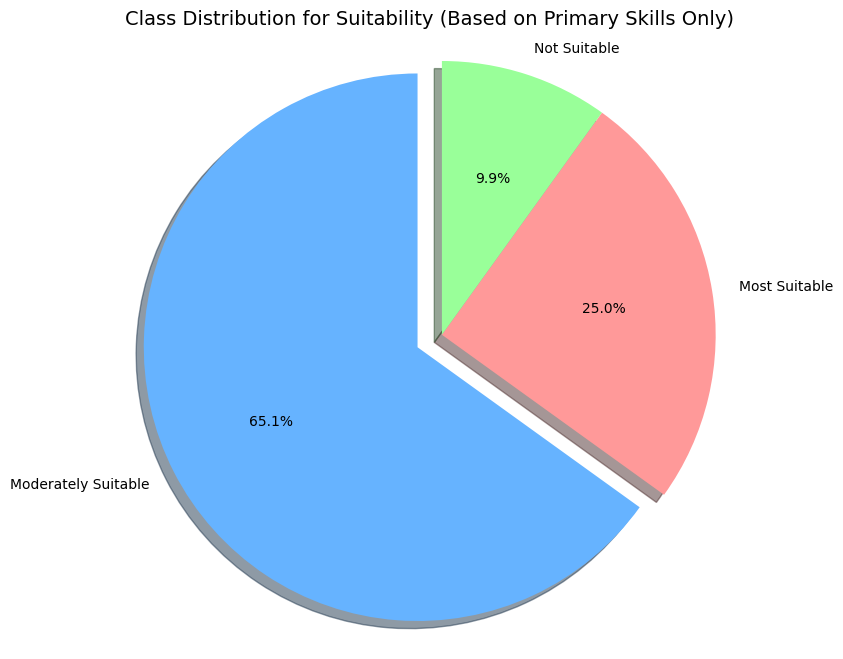


=== SUMMARY ===
Total JD records: 2513
Total CR records: 690
Total similarity pairs: 25864
Match rate: 0.00%
Neutral rate: 0.00%
Mismatch rate: 0.00%


In [ ]:

# Kiểm tra phân bố nhãn
class_counts = df_similarity['suitability_label'].value_counts()
print("\nPhân bố nhãn Suitability:")
print(class_counts)
print(f"\nTổng số cặp JD-CR: {len(df_similarity)}")

# Thống kê điểm similarity
print(f"\nThống kê Primary Skills Similarity:")
print(f"Mean: {df_similarity['primary_skills_sim'].mean():.4f}")
print(f"Median: {df_similarity['primary_skills_sim'].median():.4f}")
print(f"Min: {df_similarity['primary_skills_sim'].min():.4f}")
print(f"Max: {df_similarity['primary_skills_sim'].max():.4f}")

# Tạo explode động cho biểu đồ
labels = class_counts.index
sizes = class_counts.values
colors = ['#66b3ff', '#ff9999', '#99ff99'][:len(labels)]
explode = [0.1 if i == 0 else 0 for i in range(len(labels))]

# Vẽ biểu đồ tròn
plt.figure(figsize=(10, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, 
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Class Distribution for Suitability (Based on Primary Skills Only)', fontsize=14)
plt.axis('equal')
plt.savefig('class_distribution_suitability.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n=== SUMMARY ===")
print(f"Total JD records: {len(df_jd)}")
print(f"Total CR records: {len(df_cr)}")
print(f"Total similarity pairs: {len(df_similarity)}")
print(f"Match rate: {(class_counts.get('Match', 0) / len(df_similarity) * 100):.2f}%")
print(f"Neutral rate: {(class_counts.get('Neutral', 0) / len(df_similarity) * 100):.2f}%")
print(f"Mismatch rate: {(class_counts.get('Mismatch', 0) / len(df_similarity) * 100):.2f}%")

In [ ]:
pd.DataFrame(df_similarity)

,jd_id,cr_id,cr_category,jd_name,primary_skills_sim,secondary_skills_sim,adjectives_sim,adj_weight,total_similarity,suitability,scaled_adj_weight,total_similarity_v2,adj_weight_log,total_similarity_v3,suitability_label
0,JOB_0,CANDIDATE_0,Data Science,MLops Engineer,0.108696,0.333333,0.000000,38,0.442029,1,0.480519,0.442029,3.663562,0.442029,Most Suitable
1,JOB_0,CANDIDATE_1,Data Science,MLops Engineer,0.142857,0.000000,0.000000,2,0.142857,1,0.012987,0.142857,1.098612,0.142857,Moderately Suitable
2,JOB_0,CANDIDATE_2,Data Science,MLops Engineer,0.148148,0.111111,0.000000,12,0.259259,1,0.142857,0.259259,2.564949,0.259259,Moderately Suitable
3,JOB_0,CANDIDATE_3,Data Science,MLops Engineer,0.171429,0.000000,0.044444,36,0.331914,1,0.454545,0.191631,3.610918,0.331914,Moderately Suitable
4,JOB_0,CANDIDATE_4,Data Science,MLops Engineer,0.157895,0.000000,0.000000,1,0.157895,1,0.000000,0.157895,0.693147,0.157895,Moderately Suitable
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25859,JOB_2512,CANDIDATE_747,Hadoop,IOS Developer,0.041667,0.000000,0.045455,13,0.161624,1,0.155844,0.048750,2.639057,0.161624,Moderately Suitable
25860,JOB_2512,CANDIDATE_748,Hadoop,IOS Developer,0.083333,0.000000,0.054054,29,0.267182,1,0.363636,0.102989,3.401197,0.267182,Moderately Suitable
25861,JOB_2512,CANDIDATE_786,ETL Developer,IOS Developer,0.058824,0.000000,0.105263,11,0.320393,1,0.129870,0.072494,2.484907,0.320393,Moderately Suitable
25862,JOB_2512,CANDIDATE_787,ETL Developer,IOS Developer,0.043478,0.000000,0.024390,32,0.128759,1,0.402597,0.053298,3.496508,0.128759,Not Suitable


In [ ]:
cols_to_drop = ['adj_weight', 'scaled_adj_weight']
df_similarity.drop(columns=[col for col in cols_to_drop if col in df_similarity.columns], inplace=True)


In [ ]:
df_similarity.to_csv('../csv/jd_cr_similarity.csv', index=False)